# Setup

In [1]:
import multiprocessing as mp

from transformers import AutoTokenizer, BertForMaskedLM
import torch
import os
import string
import pickle
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
home_path = "../zeste/"

In [3]:
numberbatch = pickle.load(open(home_path+"numberbatch-en-19.08-en.pickle", 'rb'))

In [234]:
def softmax(v):
    e = np.exp(v)
    return e / np.sum(e)

In [21]:
mapping = {  'alt.atheism': 'atheism', # 'atheism',
             'comp.graphics': 'graphic',
             'comp.os.ms-windows.misc': 'windows',
             'comp.sys.ibm.pc.hardware': 'hardware',
             'comp.sys.mac.hardware': 'hardware',
             'comp.windows.x': 'windows',
             'misc.forsale': 'sale',
             'rec.autos': 'car',
             'rec.motorcycles': 'motorcycle',
             'rec.sport.baseball': 'baseball',
             'rec.sport.hockey': 'hockey',
             'sci.crypt': 'cryptography',
             'sci.electronics': 'electronics',
             'sci.med': 'medicine',
             'sci.space': 'space',
             'soc.religion.christian': 'christianity',
             'talk.politics.guns': 'gun',
             'talk.politics.mideast': 'middle_east',
             'talk.politics.misc': 'politics',
             'talk.religion.misc': 'religion' }

labels = sorted(set(mapping.values()))
print(len(labels))
print(labels)

18
['atheism', 'baseball', 'car', 'christianity', 'cryptography', 'electronics', 'graphic', 'gun', 'hardware', 'hockey', 'medicine', 'middle_east', 'motorcycle', 'politics', 'religion', 'sale', 'space', 'windows']


In [27]:
labels_mapping = {'atheism':'Atheism', 
                  'baseball':'Baseball', 
                  'car': 'A car', 
                  'christianity': 'Christianity', 
                  'cryptography': 'Cryptography', 
                  'electronics': 'Electronics', 
                  'graphic': 'Graphics', 
                  'gun': 'A gun', 
                  'hardware': 'Hardware', 
                  'hockey': 'Hockey', 
                  'medicine': 'Medicine', 
                  'middle_east': 'The Middle East', 
                  'motorcycle': 'A motorcycle', 
                  'politics': 'Politics', 
                  'religion': 'Religion', 
                  'sale': 'A sale', 
                  'space': 'Space', 
                  'windows': 'Windows'
}

In [18]:
options = {
    'model_name': 'bert-large-uncased',#'bert-base-uncased',
    'prompt': {},
}

In [31]:
tokenizer = AutoTokenizer.from_pretrained(options['model_name'])
bert = BertForMaskedLM.from_pretrained(options['model_name'])

bert_vocab = tokenizer.get_vocab()
reverse_vocab = {i:w for w,i in bert_vocab.items()}
len(bert_vocab)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


30522

In [137]:
options['prompt']['atheism'] = 'Disbelief or lack of belief in the existence of God or gods.'
options['prompt']['baseball'] = 'Baseball is a bat-and-ball game played between two opposing teams, typically of nine players each, that take turns batting and fielding.'
options['prompt']['car'] = 'A car or automobile is a wheeled motor vehicle used for transportation. Most definitions of cars say that they run primarily on roads, seat one-to-eight people, have four wheels and mainly transport people rather than goods.'
options['prompt']['christianity'] = 'Christianity is an Abrahamic, monotheistic religion based on the life and teachings of Jesus of Nazareth. It is the world\'s largest religion.'
options['prompt']['cryptography'] = 'Cryptography or cryptology is the practice and study of techniques for secure communication in the presence of adversarial behavior.'
options['prompt']['electronics'] = 'Electronics comprises the physics, engineering, technology and applications that deal with the emission, flow and control of electrons in vacuum and matter.'
options['prompt']['graphic'] = 'Graphics are visual images or designs on some surface, such as a wall, canvas, screen, paper, or stone to inform, illustrate, or entertain. It includes a pictorial representation of data, as in design and manufacture, in typesetting and the graphic arts, and in educational and recreational software.'
options['prompt']['gun'] = 'A gun is a ranged weapon designed to use a shooting tube (gun barrel) to launch typically solid projectiles'
options['prompt']['hardware'] = 'Computer hardware includes the physical parts of a computer, such as the case, central processing unit (CPU), monitor, mouse, keyboard, computer data storage, graphics card, sound card, speakers and motherboard.'
options['prompt']['hockey'] = 'Hockey is a sport in which two teams play against each other by trying to manoeuvre a ball or a puck into the opponent\'s goal using a hockey stick'
options['prompt']['medicine'] = 'Medicine is the science and practice of caring for a patient, managing the diagnosis, prognosis, prevention, treatment, palliation of their injury or disease, and promoting their health.'
options['prompt']['middle_east'] = 'The Middle East is a geopolitical term that commonly refers to the region spanning the Levant, Arabian Peninsula, Anatolia (including modern Turkey and Cyprus), Egypt, Iran and Iraq.'
options['prompt']['motorcycle'] = 'A motorcycle, often called a motorbike, bike, or cycle, is a two- or three-wheeled motor vehicle.'
options['prompt']['politics'] = 'Politics is the set of activities that are associated with making decisions in groups, or other forms of power relations between individuals, such as the distribution of resources or status.'
options['prompt']['religion'] = 'Religion is a social-cultural system of designated behaviors and practices, morals, beliefs, worldviews, texts, sanctified places, prophecies, ethics, or organizations, that relates humanity to supernatural, transcendental, and spiritual elements.'
options['prompt']['sale'] = 'Sales are activities related to selling or the number of goods sold in a given targeted time period. The delivery of a service for a cost is also considered a sale.'
options['prompt']['space'] = 'Outer space is the expanse that exists beyond Earth and between celestial bodies.'
options['prompt']['windows'] = 'Windows is a group of several proprietary graphical operating system families, all of which are developed and marketed by Microsoft. Each family caters to a certain sector of the computing industry.'

In [186]:
def get_LM_neighborhood(label, prompt, labels_mapping=labels_mapping):
    candidates_scores = {}
    
    template = f"{prompt} [SEP] {labels_mapping[label]} is related to {tokenizer.mask_token}."
    tokens_idx = tokenizer.encode(template)
    
    tokens = tokenizer.convert_ids_to_tokens(tokens_idx)

    scores = bert(torch.tensor([tokens_idx]))[0][0][-3].detach().numpy()
    best_score = np.max(scores)
    candidates_scores = sorted([(reverse_vocab[i], s/best_score) for i,s in enumerate(scores)], key=lambda c: -c[1])

    neighborhood = dict(candidates_scores)
    neighborhood[label] = 1.0
    
    return neighborhood

In [235]:
def get_LM_neighborhood_softmax(label, prompt, labels_mapping=labels_mapping):
    candidates_scores = {}
    
    template = f"{prompt} [SEP] {labels_mapping[label]} is related to {tokenizer.mask_token}."
    tokens_idx = tokenizer.encode(template)
    
    tokens = tokenizer.convert_ids_to_tokens(tokens_idx)

    scores = bert(torch.tensor([tokens_idx]))[0][0][-3].detach().numpy()
    best_score = np.max(scores)
    candidates_scores = sorted([(reverse_vocab[i], s) for i,s in enumerate(softmax(scores))], key=lambda c: -c[1])

    neighborhood = dict(candidates_scores)
    neighborhood[label] = 1.0
    
    return neighborhood

In [190]:
len(get_LM_neighborhood('atheism', 'disbelief or lack of belief in the existence of God or gods.'))

30523

In [198]:
pickle.dump(cn_ath, open('conceptnet_scores.pickle', 'wb'))
pickle.dump(lm_ath, open('bert_scores.pickle', 'wb'))

In [212]:
%time
LM_neighborhoods = {l:get_LM_neighborhood(l, options['prompt'][l]) for l in tqdm(options['prompt'])}

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 25.7 µs


In [236]:
%time
LM_neighborhoods_softmax = {l:get_LM_neighborhood_softmax(l, options['prompt'][l]) for l in tqdm(options['prompt'])}

CPU times: user 16 µs, sys: 1e+03 ns, total: 17 µs
Wall time: 30 µs


In [237]:
LM_neighborhoods_softmax['atheism']

{'religion': 0.44811785,
 'skepticism': 0.080661714,
 'god': 0.037559044,
 'belief': 0.033929985,
 'homosexuality': 0.02759404,
 'christianity': 0.027554095,
 'faith': 0.016609443,
 'heresy': 0.010879336,
 'racism': 0.009932178,
 'spirituality': 0.0089517785,
 'science': 0.008794547,
 'beliefs': 0.008422828,
 'atheist': 0.008419102,
 'morality': 0.008392472,
 'ethics': 0.008371273,
 'sin': 0.008273989,
 'disbelief': 0.007687174,
 'philosophy': 0.007628225,
 'evolution': 0.007536701,
 'buddhism': 0.0071940944,
 'judaism': 0.006255883,
 'evil': 0.005630878,
 'theology': 0.0052437373,
 'ignorance': 0.004798401,
 'witchcraft': 0.0044038314,
 'suicide': 0.0043790676,
 'scientology': 0.004131717,
 'denial': 0.0034831227,
 'biology': 0.003354267,
 'religions': 0.0031598685,
 'hinduism': 0.00283522,
 'death': 0.0026720292,
 'communism': 0.0026099486,
 'satan': 0.0025779777,
 'abortion': 0.0024110437,
 'fear': 0.0023869528,
 'islam': 0.0023666085,
 'divinity': 0.0023576617,
 '##ism': 0.00219859

In [238]:
LM_neighborhoods['atheism']

{'religion': 13.05688,
 'skepticism': 11.342088,
 'god': 10.577738,
 'belief': 10.476123,
 'homosexuality': 10.2694235,
 'christianity': 10.267975,
 'faith': 9.761795,
 'heresy': 9.338689,
 'racism': 9.247603,
 'spirituality': 9.143676,
 'science': 9.125956,
 'beliefs': 9.082769,
 'atheist': 9.082327,
 'morality': 9.079159,
 'ethics': 9.07663,
 'sin': 9.06494,
 'disbelief': 8.991377,
 'philosophy': 8.983679,
 'evolution': 8.971608,
 'buddhism': 8.925084,
 'judaism': 8.785346,
 'evil': 8.680089,
 'theology': 8.608858,
 'ignorance': 8.520106,
 'witchcraft': 8.4342985,
 'suicide': 8.428659,
 'scientology': 8.370517,
 'denial': 8.199753,
 'biology': 8.162057,
 'religions': 8.102354,
 'hinduism': 7.993943,
 'death': 7.934662,
 'communism': 7.9111543,
 'satan': 7.898829,
 'abortion': 7.8318834,
 'fear': 7.8218412,
 'islam': 7.8132815,
 'divinity': 7.809494,
 '##ism': 7.739642,
 'insanity': 7.733199,
 'ideology': 7.7143946,
 'poverty': 7.688135,
 'prejudice': 7.6849504,
 'creation': 7.6777887

In [144]:
def get_conceptnet_neighborhood(word, depth=2, allowed_rels='all', keep='top20000'):
    neighborhood_all = pickle.load(open('/data/zeste_cache/neighborhoods/'+word+'.pickle', 'rb'))
    neighborhood_words = list(neighborhood_all.keys())
    
    if allowed_rels != 'all':
        for n in neighborhood_words:
            if all(rel not in get_word_neighborhood[n]['rels'] for rel in allowed_rels):
                del neighborhood_all[n]
                continue
    
    neighborhood_words = list(neighborhood_all.keys())
    neighborhood = {w: neighborhood_all[w]['sim'] for w in neighborhood_words}

    to_visit_next = neighborhood_words

    while depth > 1:
        additions = []
        while len(to_visit_next) > 0:
            w = to_visit_next.pop()
            nn = get_conceptnet_neighborhood(w, depth=1, allowed_rels=allowed_rels)
            for ww in nn:
                if ww not in neighborhood:
                    if word in numberbatch and ww in numberbatch:
                        neighborhood[ww] = numberbatch.similarity(word, ww)
                        additions.append(ww)
                    else:
                        neighborhood[ww] = 0.0
        to_visit_next = additions
        depth -= 1
    
    if keep.startswith('top'):
        k = int(keep.split('top')[1])
        all_scores = [neighborhood[kw] for kw in neighborhood]
        all_words = list(neighborhood.keys())
        if k < len(all_scores):
            lowest_top = sorted(all_scores, reverse=True)[k]
            for kw in all_words:
                if neighborhood[kw] <= lowest_top:
                    del neighborhood[kw]
    
    return neighborhood

In [145]:
CN_neighborhoods = {l: get_conceptnet_neighborhood(l, 3) for l in tqdm(labels)}

In [146]:
def get_filtered_neighborhood_1hop(word, prompt, depth=2, lm_top=3000, allowed_rels='all', keep='top20000'):
    neighborhood_all = pickle.load(open('/data/zeste_cache/neighborhoods/'+word+'.pickle', 'rb'))
    neighborhood_words = list(neighborhood_all.keys())
    
    if allowed_rels != 'all':
        for n in neighborhood_words:
            if all(rel not in get_word_neighborhood[n]['rels'] for rel in allowed_rels):
                del neighborhood_all[n]
                continue
    
    neighborhood_words = list(neighborhood_all.keys())
    neighborhood = {w: neighborhood_all[w]['sim'] for w in neighborhood_words}
    
    lmn = get_LM_neighborhood(word, prompt)
    
    lmn_top = dict(sorted(lmn.items(), key=lambda x: -x[1])[:lm_top])
    neighborhood = {w:s for w,s in neighborhood.items() if w in lmn_top}
    to_visit_next = list(neighborhood.keys())

    while depth > 1:
        additions = []
        while len(to_visit_next) > 0:
            w = to_visit_next.pop()
            nn = get_conceptnet_neighborhood(w, depth=1, allowed_rels=allowed_rels)
            for ww in nn:
                if ww not in neighborhood:
                    if word in numberbatch and ww in numberbatch:
                        neighborhood[ww] = numberbatch.similarity(word, ww)
                        additions.append(ww)
                    else:
                        neighborhood[ww] = 0.0
        to_visit_next = additions
        depth -= 1
    
    if keep.startswith('top'):
        k = int(keep.split('top')[1])
        all_scores = [neighborhood[kw] for kw in neighborhood]
        all_words = list(neighborhood.keys())
        if k < len(all_scores):
            lowest_top = sorted(all_scores, reverse=True)[k]
            for kw in all_words:
                if neighborhood[kw] <= lowest_top:
                    del neighborhood[kw]
    
    return neighborhood

In [149]:
fn_1 = {l: get_filtered_neighborhood_1hop(l, options['prompt'][l], 3) for l in tqdm(labels)}

In [157]:
def preprocess(doc):
    doc = ''.join(c for c in doc if c not in string.punctuation or c == ' ').lower()
    doc_tokens = doc.split(' ')
    doc_tokens = [w.lower() for w in doc_tokens]
    doc_tokens = [w for w in doc_tokens if w not in stopwords.words('english')]
    doc_tokens = [w.replace('"', '').replace('?', '') for w in doc_tokens]
    doc_tokens = [w.replace('-', '_') for w in doc_tokens if w != '']

    return doc_tokens

In [158]:
pickle.dump(fn_1, open('fn_1_top3000.pickle', 'wb'))

In [159]:
"""%%time

if os.path.exists(home_path+'labels_cgr_20ng.pickle'):
    labels_cgr = pickle.load(open(home_path+'labels_cgr_20ng.pickle', 'rb'))

else:
    pbar = tqdm(labels)
    labels_cgr = {}
    for label in pbar:
        pbar.set_description(label)
        labels_cgr[label] = get_words_neighborhood(label, 3, 'all', keep='top20000')"""

"%%time\n\nif os.path.exists(home_path+'labels_cgr_20ng.pickle'):\n    labels_cgr = pickle.load(open(home_path+'labels_cgr_20ng.pickle', 'rb'))\n\nelse:\n    pbar = tqdm(labels)\n    labels_cgr = {}\n    for label in pbar:\n        pbar.set_description(label)\n        labels_cgr[label] = get_words_neighborhood(label, 3, 'all', keep='top20000')"

# Evaluation

In [160]:
ds_20ng = pd.read_csv(home_path+'datasets/20ng_preprocessed_dataset.csv')
ds_20ng.head()

Unnamed: 0                  label  \
0           0              rec.autos   
1           1  comp.sys.mac.hardware   
2           2  comp.sys.mac.hardware   
3           3          comp.graphics   
4           4              sci.space   

                                                text  
0  car wondering anyone could enlighten car saw d...  
1  clock poll final call summary final call clock...  
2  question well folk mac plus finally gave ghost...  
3  weitek robert kyanko wrote writes far low leve...  
4  shuttle launch question error wondering expect...

In [169]:
true_labels = [mapping[l] for l in ds_20ng.label.tolist()]

In [230]:
def get_document_score(doc, label_neighborhood, LM_neighborhood=None):
    # tokens = preprocess(doc)
    if type(doc) == str:
        doc = doc.split(' ')
    tokens = doc
    related_words = []
    score = 0
    for token in tokens: 
        if token in label_neighborhood:
            similarity = label_neighborhood[token] 
            if LM_neighborhood and token in LM_neighborhood and similarity > 0:
                score += similarity * LM_neighborhood[token]
            if similarity > 0:
                # related_words.append((token, label_neighborhood[token]['rels'][0], similarity))
                score += similarity

    return score# , sorted(related_words, key=lambda t: -t[-1])

In [231]:
def scoring_document_CN(doc, labels=CN_neighborhoods):
    return np.argmax([get_document_score(doc, labels[l]) for l in labels])

def scoring_document_LM(doc, labels=LM_neighborhoods):
    return np.argmax([get_document_score(doc, labels[l]) for l in labels])

def scoring_document_filtered(doc, labels=fn_1):
    return np.argmax([get_document_score(doc, labels[l]) for l in labels])

def scoring_document_combined(doc, labels=fn_1):
    return np.argmax([get_document_score(doc, labels[l], LM_neighborhood=LM_neighborhoods[l]) for l in labels])

def generate_predictions_CN(corpus_preprocessed):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions = pool.map(scoring_document_CN, corpus_preprocessed)
    return predictions

def generate_predictions_LM(corpus_preprocessed):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions = pool.map(scoring_document_LM, corpus_preprocessed)
    return predictions

def generate_predictions_filtered(corpus_preprocessed):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions = pool.map(scoring_document_filtered, corpus_preprocessed)
    return predictions

def generate_predictions_combined(corpus_preprocessed):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions = pool.map(scoring_document_combined, corpus_preprocessed)
    return predictions

In [226]:
print("Number of processors: ", mp.cpu_count())

Number of processors:  32


In [227]:
%%time
pool = mp.Pool(mp.cpu_count())
data_20ng = pool.map(preprocess, ds_20ng.text)
pool.close()

CPU times: user 926 ms, sys: 5.15 s, total: 6.07 s
Wall time: 15.2 s


In [228]:
get_document_score(data_20ng[0], fn_1['car'])

7.8526013642549515

In [170]:
%%time
predictions_CN = generate_predictions_CN(data_20ng)
prediction_labels_CN = [labels[p] for p in predictions_CN]

print(classification_report(prediction_labels_CN, true_labels, digits=3))

              precision    recall  f1-score   support

     atheism      0.427     0.407     0.417       504
    baseball      0.906     0.836     0.870       647
         car      0.840     0.591     0.694       844
christianity      0.698     0.608     0.650       688
cryptography      0.746     0.693     0.718       641
 electronics      0.514     0.636     0.569       478
     graphic      0.526     0.458     0.489       671
         gun      0.681     0.717     0.699       519
    hardware      0.592     0.557     0.574      1242
      hockey      0.840     0.880     0.859       573
    medicine      0.559     0.895     0.688       371
 middle_east      0.670     0.849     0.749       445
  motorcycle      0.625     0.928     0.747       403
    politics      0.447     0.466     0.457       446
    religion      0.167     0.194     0.180       324
        sale      0.482     0.405     0.440       697
       space      0.821     0.696     0.753       700
     windows      0.615    

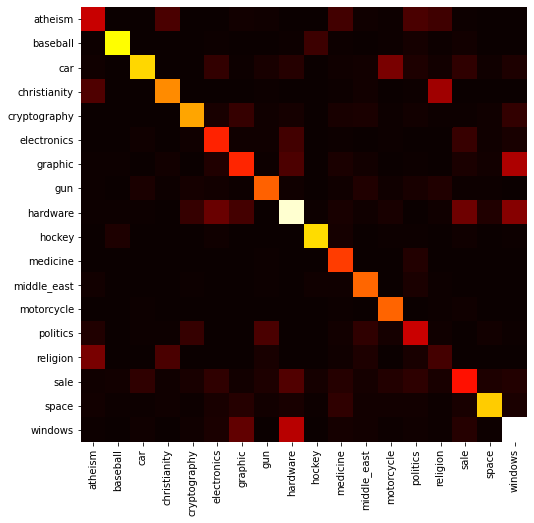

In [172]:
cm = confusion_matrix(prediction_labels_CN, true_labels)
cm_df = pd.DataFrame(cm, columns = labels, index = labels)
plt.figure(figsize=(8, 8))
sns.heatmap(cm_df, cmap='hot', cbar=False)

In [175]:
%%time
predictions_LM = generate_predictions_LM(data_20ng)
prediction_labels_LM = [labels[p] for p in predictions_LM]

print(classification_report(prediction_labels_LM, true_labels, digits=3))

              precision    recall  f1-score   support

     atheism      0.365     0.249     0.296       703
    baseball      0.538     0.549     0.543       585
         car      0.015     0.148     0.027        61
christianity      0.190     0.270     0.223       422
cryptography      0.528     0.707     0.604       444
 electronics      0.166     0.336     0.222       292
     graphic      0.291     0.271     0.281       627
         gun      0.299     0.454     0.360       359
    hardware      0.584     0.312     0.406      2189
      hockey      0.222     0.747     0.342       178
    medicine      0.596     0.551     0.572       643
 middle_east      0.225     0.623     0.331       204
  motorcycle      0.497     0.412     0.451       720
    politics      0.602     0.218     0.320      1286
    religion      0.212     0.237     0.224       338
        sale      0.356     0.208     0.263       999
       space      0.401     0.465     0.431       512
     windows      0.246    

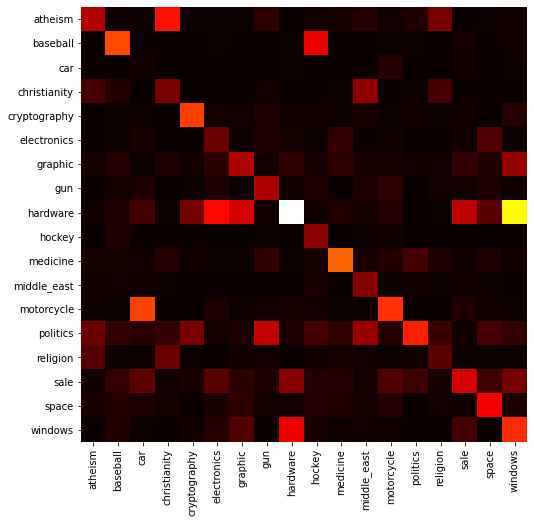

In [176]:
cm = confusion_matrix(prediction_labels_LM, true_labels)
cm_df = pd.DataFrame(cm, columns = labels, index = labels)
plt.figure(figsize=(8, 8))
sns.heatmap(cm_df, cmap='hot', cbar=False)

In [179]:
%%time
predictions_filtered = generate_predictions_filtered(data_20ng)
prediction_labels_filtered = [labels[p] for p in predictions_filtered]

print(classification_report(prediction_labels_filtered, true_labels, digits=3))

              precision    recall  f1-score   support

     atheism      0.502     0.377     0.430       640
    baseball      0.913     0.841     0.876       648
         car      0.833     0.616     0.708       804
christianity      0.681     0.607     0.642       672
cryptography      0.758     0.664     0.708       679
 electronics      0.536     0.642     0.584       494
     graphic      0.521     0.457     0.487       665
         gun      0.674     0.717     0.695       513
    hardware      0.598     0.571     0.584      1223
      hockey      0.833     0.890     0.861       562
    medicine      0.552     0.906     0.686       362
 middle_east      0.667     0.856     0.750       439
  motorcycle      0.671     0.922     0.776       435
    politics      0.456     0.462     0.459       459
    religion      0.133     0.197     0.158       254
        sale      0.475     0.414     0.443       671
       space      0.825     0.707     0.761       692
     windows      0.610    

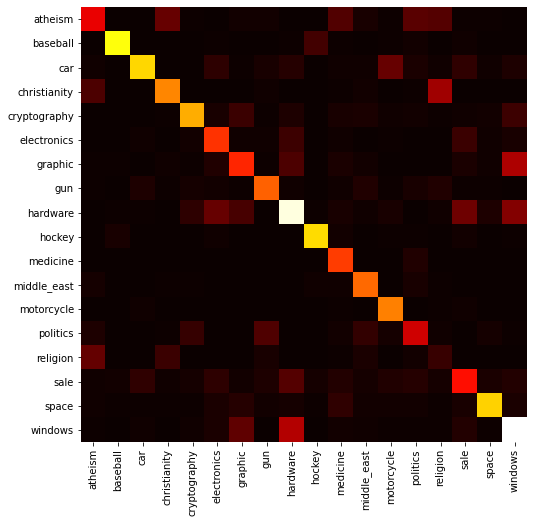

In [178]:
cm = confusion_matrix(prediction_labels_filtered, true_labels)
cm_df = pd.DataFrame(cm, columns = labels, index = labels)
plt.figure(figsize=(8, 8))
sns.heatmap(cm_df, cmap='hot', cbar=False)

In [232]:
%%time
predictions_combined = generate_predictions_combined(data_20ng)
prediction_labels_comined = [labels[p] for p in predictions_combined]

print(classification_report(prediction_labels_comined, true_labels, digits=3))

              precision    recall  f1-score   support

     atheism      0.392     0.389     0.390       483
    baseball      0.811     0.818     0.814       592
         car      0.754     0.542     0.631       826
christianity      0.671     0.502     0.575       800
cryptography      0.704     0.655     0.679       640
 electronics      0.320     0.645     0.428       293
     graphic      0.443     0.391     0.416       662
         gun      0.700     0.621     0.658       615
    hardware      0.549     0.377     0.447      1702
      hockey      0.712     0.849     0.774       503
    medicine      0.559     0.824     0.666       403
 middle_east      0.569     0.735     0.641       437
  motorcycle      0.701     0.843     0.765       497
    politics      0.415     0.434     0.424       445
    religion      0.183     0.261     0.215       264
        sale      0.535     0.451     0.489       694
       space      0.712     0.560     0.627       754
     windows      0.343    